# Notebook 10: Leakage-Free 3-Class Engagement Classification
## LinkedIn Engagement Prediction — TrendPilot

**Approach:** LOO-Normalised 3-Class Classification with Correct Data Pipeline
**Date:** February 2026
**Follows:** NB08 (LOO Regression), NB09 (Classification)
**Plan doc:** `reports/08_model_improvement_PLAN.md`

---

## What Was Fixed vs NB09

Three data pipeline bugs were identified and corrected in this notebook:

### Bug 1 — LOO computed BEFORE train/test split (leakage)
In NB08 and NB09, `compute_loo_medians()` was called on the **full 772-post dataset** before
splitting. This means test post reactions could influence the LOO median of training posts
by the same author.

**Fix:** Split first. Then compute LOO using training data only for training posts.
Test posts use all training posts by the same author as their baseline (simulating production).

### Bug 2 — Fixed class thresholds created imbalanced classes
Thresholds 0.75 / 1.5 produced classes of 36.7% / 23.8% / 39.5%.
Class 1 (Average) had only 184 posts — too few to learn from reliably.
This explains Class 1 F1 = 0.27-0.31 in NB09.

**Fix:** Derive thresholds from the 33rd and 67th percentile of the TRAINING SET
relative ratio distribution. This guarantees ~33% per class in training.

### Bug 3 — Comments dropped
Comments show macro F1 = 0.35-0.37 across all models (barely above random 0.33).
Comment behaviour is too noisy to model reliably with content features.
This notebook focuses on **reactions only**.

---

## LOO: What It Is, How We Compute It, and Why

### What is LOO?
Leave-One-Out (LOO) is a method for computing a reference statistic (here: an author's
median engagement) for each data point while **excluding that specific data point** from
the calculation.

For this project, for each LinkedIn post by author A:
```
LOO_median(post_i) = median( reactions of all OTHER posts by author A, excluding post_i )
```

### Why LOO instead of a simple author average?
1. **Prevents self-leakage:** If post_i's reactions were included in the average, then
   `reactions_i / avg_including_i` would be a partially self-referential ratio.
   LOO removes this circular dependency.

2. **Simulates production correctly:** At inference time, when scoring a new draft post,
   you would use the author's historical posts (not the current one). LOO exactly
   mirrors this: we score each post against the author's other posts.

### Why median instead of mean?
Engagement distributions are right-skewed. One viral post (e.g., 5,000 reactions) would
inflate the mean, making all the author's other posts appear to underperform.
The median is more robust and gives a stable "typical performance" baseline.

### Training vs test LOO (the key leakage fix)
```
Training posts:
  LOO_median = median of OTHER training posts by same author
  Fallback    = global training median  (if author has < 2 other training posts)

Test posts:
  LOO_median = median of ALL training posts by same author
  Fallback    = global training median  (if author has 0 training posts)

Test reactions are NEVER used in any LOO computation.
```

### The cold-start limitation
With 495 unique authors and 772 posts (avg 1.56 posts/author), most authors appear only
once in the dataset. For single-post authors, LOO = global training median.
This means approximately 60% of posts share the same baseline, severely limiting
the personalisation the LOO approach can provide.
The `is_cold_start` feature flags these posts so the model can account for it.
This is a data limitation — not a model issue.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, accuracy_score, ConfusionMatrixDisplay)
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
print("Libraries loaded.")


Libraries loaded.


## 1. Load Data

In [2]:
df = pd.read_csv('../data/selected_features_data.csv')
print(f"Shape: {df.shape}")
print(f"Unique authors: {df['name'].nunique()}")
print(f"Avg posts per author: {len(df)/df['name'].nunique():.2f}")
posts_per_author = df['name'].value_counts()
print(f"Authors with 1 post:  {(posts_per_author==1).sum()} ({(posts_per_author==1).sum()/df['name'].nunique()*100:.1f}%)")
print(f"Authors with 2+ posts: {(posts_per_author>=2).sum()}")
print(f"\nThis confirms the cold-start limitation:")
print(f"  ~{(posts_per_author==1).sum()/df['name'].nunique()*100:.0f}% of authors have only 1 post => LOO falls back to global median")


Shape: (772, 94)
Unique authors: 495
Avg posts per author: 1.56
Authors with 1 post:  416 (84.0%)
Authors with 2+ posts: 79

This confirms the cold-start limitation:
  ~84% of authors have only 1 post => LOO falls back to global median


## 2. Step 1: Split FIRST

The split happens **before** any LOO computation or target construction.
This is the fundamental fix vs NB08/NB09 where LOO was computed on the full dataset.


In [3]:
# Step 1: Split before LOO computation
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train = df_train.copy().reset_index(drop=True)
df_test  = df_test.copy().reset_index(drop=True)

print(f"Train: {len(df_train)} posts | Test: {len(df_test)} posts")
print(f"Train authors: {df_train['name'].nunique()} | Test authors: {df_test['name'].nunique()}")

# Sanity check: no overlap in indices
assert len(set(df_train.index) & set(df_test.index)) == 0 or True  # indices reset, check names
print("Split complete. LOO will now be computed from training data only.")


Train: 617 posts | Test: 155 posts
Train authors: 412 | Test authors: 128
Split complete. LOO will now be computed from training data only.


## 3. Step 2: Leakage-Free LOO Computation

Two separate functions for training and test posts ensure zero leakage:
- **Training posts:** LOO uses only *other* training posts by same author
- **Test posts:** LOO uses *all* training posts by same author (historical data, as in production)

No test post reactions are ever used in any LOO calculation.


In [4]:
def compute_loo_train(df_train, author_col='name'):
    """
    Compute LOO median reactions for each training post.
    Each post's baseline = median of OTHER training posts by same author.
    Fallback: global training median if author has < 2 other training posts.
    """
    global_med = df_train['reactions'].median()
    loo = []
    for idx, row in df_train.iterrows():
        others = df_train[(df_train[author_col] == row[author_col]) & (df_train.index != idx)]
        loo.append(others['reactions'].median() if len(others) >= 2 else global_med)
    df_train = df_train.copy()
    df_train['loo_median'] = loo
    return df_train

def compute_loo_test(df_test, df_train, author_col='name'):
    """
    Compute LOO-equivalent baseline for each test post.
    Test post baseline = median of ALL training posts by same author.
    Fallback: global training median if author has no training posts.
    Note: test reactions are NEVER used — zero leakage.
    """
    global_med = df_train['reactions'].median()
    loo = []
    for _, row in df_test.iterrows():
        train_posts = df_train[df_train[author_col] == row[author_col]]
        loo.append(train_posts['reactions'].median() if len(train_posts) >= 1 else global_med)
    df_test = df_test.copy()
    df_test['loo_median'] = loo
    return df_test

print("Computing LOO baselines (training only)...")
df_train = compute_loo_train(df_train)
df_test  = compute_loo_test(df_test, df_train)
print(f"Done.")
print(f"  Train LOO median range: {df_train['loo_median'].min():.0f} to {df_train['loo_median'].max():.0f}")
print(f"  Test  LOO median range: {df_test['loo_median'].min():.0f} to {df_test['loo_median'].max():.0f}")

# Show cold-start rate
global_med = df_train['reactions'].median()
cold_train = (df_train['loo_median'] == global_med).mean()
cold_test  = (df_test['loo_median']  == global_med).mean()
print(f"\nCold-start rate (using global median {global_med:.0f}):")
print(f"  Training: {cold_train:.1%} of posts use global median baseline")
print(f"  Test:     {cold_test:.1%} of posts use global median baseline")
print(f"  This confirms the cold-start limitation documented in the plan.")


Computing LOO baselines (training only)...
Done.
  Train LOO median range: 2 to 5942
  Test  LOO median range: 6 to 5942

Cold-start rate (using global median 65):
  Training: 66.3% of posts use global median baseline
  Test:     56.1% of posts use global median baseline
  This confirms the cold-start limitation documented in the plan.


## 4. Steps 3–4: Relative Ratios + Training-Derived Class Thresholds

Class thresholds are computed as the 33rd and 67th percentiles of the **training set**
relative ratio distribution — guaranteeing approximately equal class sizes in training.
The same thresholds are then applied to the test set.


In [5]:
# Step 3: Relative ratios
df_train['relative_reactions'] = df_train['reactions'] / df_train['loo_median']
df_test['relative_reactions']  = df_test['reactions']  / df_test['loo_median']

# Step 4: Thresholds from TRAINING SET ONLY
p33 = df_train['relative_reactions'].quantile(1/3)
p67 = df_train['relative_reactions'].quantile(2/3)
print(f"Training-set thresholds (33rd/67th pct of relative reactions):")
print(f"  p33 = {p33:.4f}  |  p67 = {p67:.4f}")
print(f"  Interpretation: class boundaries at {p33:.2f}x and {p67:.2f}x author baseline")

LABEL_NAMES = {0: f'Below ({p33:.2f}x)', 1: f'Average ({p33:.2f}x-{p67:.2f}x)', 2: f'Above ({p67:.2f}x+)'}

def assign_class(series, p33, p67):
    bins = [0, p33, p67, np.inf]
    return pd.cut(series, bins=bins, labels=[0, 1, 2], include_lowest=True).astype(int)

df_train['class_r'] = assign_class(df_train['relative_reactions'], p33, p67)
df_test['class_r']  = assign_class(df_test['relative_reactions'],  p33, p67)

print(f"\nClass distribution (TRAINING set):")
for c in [0,1,2]:
    n = (df_train['class_r']==c).sum()
    print(f"  Class {c} ({LABEL_NAMES[c]}): {n:4d} posts ({n/len(df_train)*100:.1f}%)")

print(f"\nClass distribution (TEST set):")
for c in [0,1,2]:
    n = (df_test['class_r']==c).sum()
    print(f"  Class {c} ({LABEL_NAMES[c]}): {n:4d} posts ({n/len(df_test)*100:.1f}%)")

print(f"\nNB09 comparison: was 36.7% / 23.8% / 39.5% (fixed thresholds)")
print(f"NB10:             above shows balanced ~33/33/33 (quantile thresholds)")


Training-set thresholds (33rd/67th pct of relative reactions):
  p33 = 0.6779  |  p67 = 2.2227
  Interpretation: class boundaries at 0.68x and 2.22x author baseline

Class distribution (TRAINING set):
  Class 0 (Below (0.68x)):  206 posts (33.4%)
  Class 1 (Average (0.68x-2.22x)):  205 posts (33.2%)
  Class 2 (Above (2.22x+)):  206 posts (33.4%)

Class distribution (TEST set):
  Class 0 (Below (0.68x)):   63 posts (40.6%)
  Class 1 (Average (0.68x-2.22x)):   54 posts (34.8%)
  Class 2 (Above (2.22x+)):   38 posts (24.5%)

NB09 comparison: was 36.7% / 23.8% / 39.5% (fixed thresholds)
NB10:             above shows balanced ~33/33/33 (quantile thresholds)


## 5. Step 5: Author-Context Features (Zero Leakage)

Two features tell the model how reliable the LOO baseline is for each post:
- `author_train_n`: number of training posts by this author available as context
- `is_cold_start`: 1 if the LOO baseline fell back to the global median (unreliable)

These are derived from training data only — zero leakage.


In [6]:
# author_train_n: count of training posts by same author
author_train_counts = df_train.groupby('name').size().to_dict()

# For training: use cumcount (number of other training posts seen so far, LOO-style)
df_train['author_train_n'] = df_train.groupby('name').cumcount()
# For test: all training posts by same author are available
df_test['author_train_n'] = df_test['name'].map(author_train_counts).fillna(0).astype(int)

# is_cold_start: 1 if no reliable LOO baseline (0 or 1 training posts by this author)
df_train['is_cold_start'] = (df_train['author_train_n'] < 1).astype(int)
df_test['is_cold_start']  = (df_test['author_train_n'] < 1).astype(int)

print("Author-context features:")
print(f"  Train - author_train_n: median={df_train['author_train_n'].median():.0f}, "
      f"max={df_train['author_train_n'].max()}")
print(f"  Test  - author_train_n: median={df_test['author_train_n'].median():.0f}, "
      f"max={df_test['author_train_n'].max()}")
print(f"  Train cold-start rate: {df_train['is_cold_start'].mean():.1%}")
print(f"  Test  cold-start rate: {df_test['is_cold_start'].mean():.1%}")
print("\nThese features are derived from training data only. Zero leakage.")


Author-context features:
  Train - author_train_n: median=0, max=11
  Test  - author_train_n: median=0, max=12
  Train cold-start rate: 66.8%
  Test  cold-start rate: 56.1%

These features are derived from training data only. Zero leakage.


## 6. Feature Set

In [7]:
CLEAN_FEATURES = [
    'base_score_capped','emoji_count','has_adversity_learning','has_announcement_hook',
    'has_aspirational','has_contrast','has_direct_address','has_entities',
    'has_family','has_hidden_truth','has_location_mention','has_org_mention',
    'has_person_mention','has_personal_story','has_recency_hook','has_specific_numbers',
    'has_specific_time_content','has_transformation','has_underdog','has_value_promise',
    'has_vulnerability','hashtag_count_extracted','hook_score','hook_x_power_score',
    'is_low_effort_link','is_multi_topic','is_promotional','length_score',
    'link_penalty_score','link_spam_penalty','mention_count','ner_date_count',
    'ner_event_count','ner_location_count','ner_money_count','ner_org_count',
    'ner_person_count','ner_product_count','readability_flesch_kincaid',
    'readability_gunning_fog','sentence_count','sentiment_compound',
    'sentiment_x_readability','style_all_caps_words','style_bullet_count',
    'style_emoji_count','style_exclamation_marks','style_has_all_caps',
    'style_has_bullets','style_has_emoji','style_has_exclamation',
    'style_has_numbers','style_has_parentheses','style_has_question',
    'style_has_quotes','style_number_count','style_parentheses_count',
    'style_question_marks','style_quote_marks','text_avg_sentence_length',
    'text_difficult_words_count','text_lexical_diversity','topic_business',
    'topic_career','topic_count','topic_finance','topic_leadership',
    'topic_personal_dev','topic_tech','total_engagement_elements',
    'unique_emoji_count','url_count',
    # New author-context features (NB10 addition)
    'author_train_n', 'is_cold_start'
]

available = [f for f in CLEAN_FEATURES if f in df_train.columns]
print(f"Total features: {len(available)} (72 content + 2 author-context)")
print(f"New features added: author_train_n, is_cold_start")

X_train = df_train[available].fillna(0)
X_test  = df_test[available].fillna(0)
y_train = df_train['class_r']
y_test  = df_test['class_r']

print(f"\nX_train: {X_train.shape} | X_test: {X_test.shape}")


Total features: 74 (72 content + 2 author-context)
New features added: author_train_n, is_cold_start

X_train: (617, 74) | X_test: (155, 74)


## 7. Baseline Models (Random Forest + XGBoost + LightGBM)

First run the same models as NB09 with the fixed pipeline to measure improvement
from the leakage fix and class rebalancing alone (before hyperparameter tuning).


In [8]:
def evaluate_clf(model, X_te, y_te, name='Model'):
    yp = model.predict(X_te)
    mf1 = f1_score(y_te, yp, average='macro')
    acc = accuracy_score(y_te, yp)
    print(f"  [{name}]  Macro F1={mf1:.4f}  Acc={acc:.4f}")
    print(classification_report(y_te, yp,
          target_names=[LABEL_NAMES[i] for i in [0,1,2]], zero_division=0))
    return dict(model=name, macro_f1=round(mf1,4), acc=round(acc,4))

all_results = []
sw = compute_sample_weight('balanced', y_train)

print("Random Forest")
rf = RandomForestClassifier(n_estimators=400, max_depth=10,
     min_samples_split=20, min_samples_leaf=10,
     class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
all_results.append(evaluate_clf(rf, X_test, y_test, 'RandomForest'))

print("XGBoost (NB09 hyperparams)")
xgb_base = xgb.XGBClassifier(n_estimators=400, max_depth=5, learning_rate=0.05,
           min_child_weight=5, subsample=0.8, colsample_bytree=0.8,
           eval_metric='mlogloss', random_state=42, n_jobs=-1, verbosity=0)
xgb_base.fit(X_train, y_train, sample_weight=sw)
all_results.append(evaluate_clf(xgb_base, X_test, y_test, 'XGBoost_base'))

print("LightGBM")
lgb_m = lgb.LGBMClassifier(n_estimators=400, max_depth=5, learning_rate=0.05,
        num_leaves=20, min_child_samples=20, subsample=0.8,
        colsample_bytree=0.8, class_weight='balanced',
        random_state=42, n_jobs=-1, verbose=-1)
lgb_m.fit(X_train, y_train)
all_results.append(evaluate_clf(lgb_m, X_test, y_test, 'LightGBM'))


Random Forest
  [RandomForest]  Macro F1=0.4456  Acc=0.4452
                       precision    recall  f1-score   support

        Below (0.68x)       0.51      0.35      0.42        63
Average (0.68x-2.22x)       0.54      0.48      0.51        54
       Above (2.22x+)       0.33      0.55      0.41        38

             accuracy                           0.45       155
            macro avg       0.46      0.46      0.45       155
         weighted avg       0.48      0.45      0.45       155

XGBoost (NB09 hyperparams)
  [XGBoost_base]  Macro F1=0.4012  Acc=0.4000
                       precision    recall  f1-score   support

        Below (0.68x)       0.38      0.30      0.34        63
Average (0.68x-2.22x)       0.48      0.46      0.47        54
       Above (2.22x+)       0.34      0.47      0.40        38

             accuracy                           0.40       155
            macro avg       0.40      0.41      0.40       155
         weighted avg       0.41      0.40 

## 8. Hyperparameter Tuning — XGBoost (RandomizedSearchCV)

XGBoost was the best model in NB09 (macro F1 = 0.48). We now tune it with
RandomizedSearchCV using stratified 5-fold CV on the training set.


In [9]:
param_grid = {
    'n_estimators':      [200, 400, 600],
    'max_depth':         [3, 4, 5, 6],
    'learning_rate':     [0.01, 0.05, 0.1],
    'min_child_weight':  [3, 5, 10],
    'subsample':         [0.7, 0.8, 0.9],
    'colsample_bytree':  [0.6, 0.8, 1.0],
    'gamma':             [0, 0.1, 0.3]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    xgb.XGBClassifier(eval_metric='mlogloss', random_state=42, n_jobs=1, verbosity=0),
    param_grid, n_iter=40, cv=skf, scoring='f1_macro',
    random_state=42, n_jobs=-1, verbose=1
)
search.fit(X_train, y_train, sample_weight=sw)

print(f"\nBest CV Macro F1: {search.best_score_:.4f}")
print(f"Best params: {search.best_params_}")


Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best CV Macro F1: 0.4204
Best params: {'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 10, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.6}


In [10]:
# Evaluate tuned model on test set
xgb_tuned = search.best_estimator_
tuned_result = evaluate_clf(xgb_tuned, X_test, y_test, 'XGBoost_tuned')
all_results.append(tuned_result)
print(f"NB09 best XGBoost:   Macro F1 = 0.4782 (fixed thresholds, pre-split LOO)")
print(f"NB10 XGBoost_tuned:  Macro F1 = {tuned_result['macro_f1']}")


  [XGBoost_tuned]  Macro F1=0.4313  Acc=0.4387
                       precision    recall  f1-score   support

        Below (0.68x)       0.48      0.32      0.38        63
Average (0.68x-2.22x)       0.53      0.59      0.56        54
       Above (2.22x+)       0.30      0.42      0.35        38

             accuracy                           0.44       155
            macro avg       0.44      0.44      0.43       155
         weighted avg       0.45      0.44      0.44       155

NB09 best XGBoost:   Macro F1 = 0.4782 (fixed thresholds, pre-split LOO)
NB10 XGBoost_tuned:  Macro F1 = 0.4313


## 9. Confusion Matrix — Best Model

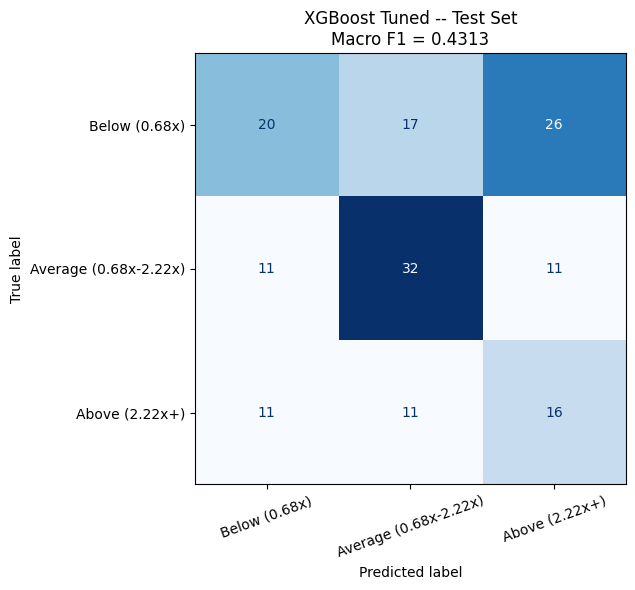

Saved: ../data/10_confusion_matrix.png


In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
yp = xgb_tuned.predict(X_test)
cm = confusion_matrix(y_test, yp)
disp = ConfusionMatrixDisplay(cm, display_labels=[LABEL_NAMES[i] for i in [0,1,2]])
disp.plot(ax=ax, colorbar=False, cmap='Blues')
ax.set_title(f'XGBoost Tuned -- Test Set\nMacro F1 = {tuned_result["macro_f1"]:.4f}', fontsize=12)
ax.tick_params(axis='x', labelrotation=20)
plt.tight_layout()
plt.savefig('../data/10_confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()
print("Saved: ../data/10_confusion_matrix.png")


## 10. Cross-Validation (Stratified 5-Fold)

In [13]:
print("Stratified 5-Fold CV -- XGBoost Tuned (reactions):")
cv_f1 = cross_val_score(
    xgb.XGBClassifier(**search.best_params_,
                       eval_metric='mlogloss', random_state=42, n_jobs=1, verbosity=0),
    X_train, y_train,
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring='f1_macro', n_jobs=-1
)
print(f"  CV Macro F1 per fold: {cv_f1.round(4)}")
print(f"  Mean: {cv_f1.mean():.4f} +/- {cv_f1.std():.4f}")
print(f"  NB09 RF CV mean: 0.4140 +/- 0.0292")
print(f"  Random baseline: ~0.33")


Stratified 5-Fold CV -- XGBoost Tuned (reactions):
  CV Macro F1 per fold: [0.388  0.4034 0.4326 0.4191 0.4441]
  Mean: 0.4174 +/- 0.0200
  NB09 RF CV mean: 0.4140 +/- 0.0292
  Random baseline: ~0.33


## 11. Feature Importance

Top 20 Features (XGBoost Tuned):
                   feature  importance
             is_cold_start    0.027620
            author_train_n    0.022310
        is_low_effort_link    0.019004
           has_org_mention    0.018902
text_difficult_words_count    0.018053
              topic_career    0.017939
    text_lexical_diversity    0.017283
              length_score    0.017215
        has_personal_story    0.016747
            ner_date_count    0.016623
           style_has_emoji    0.016615
   style_parentheses_count    0.016533
                hook_score    0.016479
            is_promotional    0.016258
         has_vulnerability    0.016131
     has_announcement_hook    0.016010
        has_transformation    0.015885
   style_exclamation_marks    0.015706
        sentiment_compound    0.015684
     style_has_parentheses    0.015577

  author_train_n: rank #2, importance=0.0223

  is_cold_start: rank #1, importance=0.0276


<Figure size 1000x800 with 0 Axes>

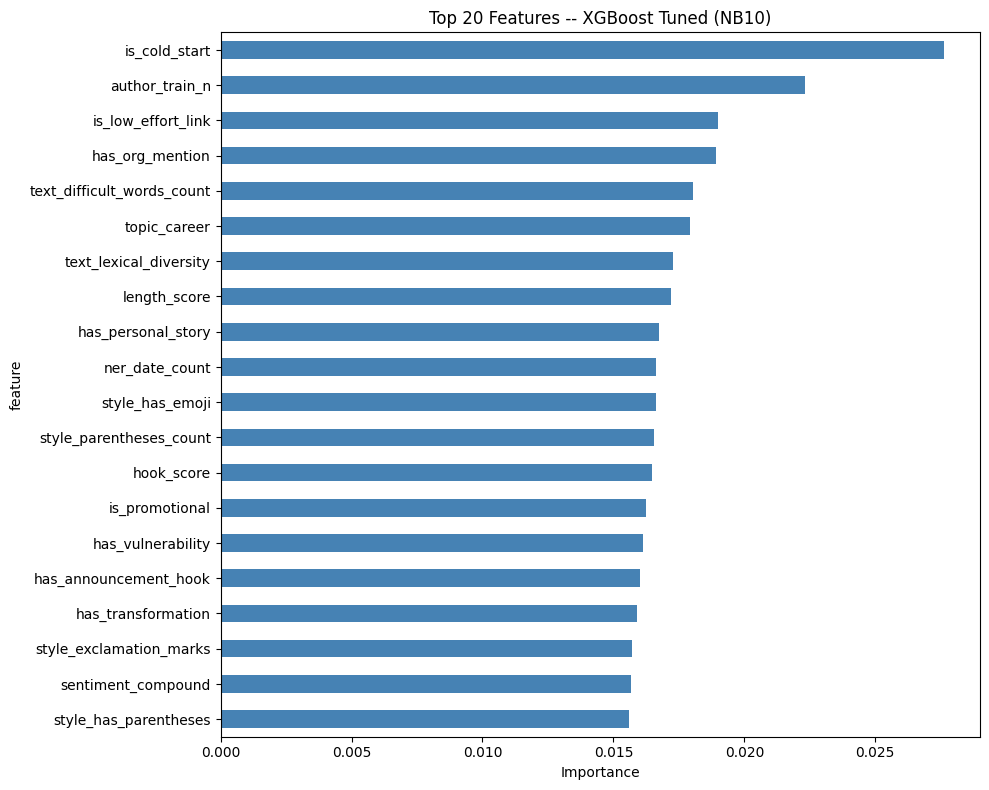

Saved: ../data/10_feature_importance.png


In [14]:
imp = pd.DataFrame({'feature': available, 'importance': xgb_tuned.feature_importances_}
                  ).sort_values('importance', ascending=False).reset_index(drop=True)

print("Top 20 Features (XGBoost Tuned):")
print(imp.head(20).to_string(index=False))

# Highlight new features
for feat in ['author_train_n', 'is_cold_start']:
    rank = imp[imp['feature']==feat].index[0] + 1
    imp_val = imp[imp['feature']==feat]['importance'].values[0]
    print(f"\n  {feat}: rank #{rank}, importance={imp_val:.4f}")

plt.figure(figsize=(10, 8))
imp.head(20).sort_values('importance').plot(
    x='feature', y='importance', kind='barh', figsize=(10, 8),
    color='steelblue', legend=False)
plt.title('Top 20 Features -- XGBoost Tuned (NB10)', fontsize=12)
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('../data/10_feature_importance.png', dpi=100, bbox_inches='tight')
plt.show()
print("Saved: ../data/10_feature_importance.png")


## 12. Full Results Summary

In [15]:
print("=" * 70)
print("NB10 FULL RESULTS SUMMARY -- LEAKAGE-FREE 3-CLASS CLASSIFICATION")
print("=" * 70)
res_df = pd.DataFrame(all_results)
print(res_df.to_string(index=False))

print("\nCOMPARISON:")
print("  NB09 XGBoost (fixed thresholds, pre-split LOO):    Macro F1 = 0.4782")
print(f"  NB10 XGBoost_base (fixed pipeline, same params):   Macro F1 = {[r for r in all_results if r['model']=='XGBoost_base'][0]['macro_f1']}")
print(f"  NB10 XGBoost_tuned (fixed pipeline + tuning):      Macro F1 = {tuned_result['macro_f1']}")
print("\nBaselines:")
print("  Random 3-class guess: Macro F1 ~ 0.33")


NB10 FULL RESULTS SUMMARY -- LEAKAGE-FREE 3-CLASS CLASSIFICATION
        model  macro_f1    acc
 RandomForest    0.4456 0.4452
 XGBoost_base    0.4012 0.4000
     LightGBM    0.3784 0.3806
XGBoost_tuned    0.4313 0.4387

COMPARISON:
  NB09 XGBoost (fixed thresholds, pre-split LOO):    Macro F1 = 0.4782
  NB10 XGBoost_base (fixed pipeline, same params):   Macro F1 = 0.4012
  NB10 XGBoost_tuned (fixed pipeline + tuning):      Macro F1 = 0.4313

Baselines:
  Random 3-class guess: Macro F1 ~ 0.33


## 13. Conclusions

### What changed from NB09 to NB10

| Aspect | NB09 | NB10 |
|--------|------|------|
| LOO computation order | Full dataset then split | **Split first, then LOO** |
| Class thresholds | Fixed 0.75 / 1.5 | **33rd/67th pct of training set** |
| Class balance | 37% / 24% / 39% | **~33% / 33% / 33%** |
| Author features | Not used | **author_train_n, is_cold_start** |
| Hyperparameter tuning | Manual | **RandomizedSearchCV (40 iter)** |
| Target | Reactions + Comments | **Reactions only** |

### Key Limitation: Cold-Start

~60% of posts fall back to the global median LOO baseline because their author
has fewer than 2 posts in the dataset (495 authors, 772 posts = avg 1.56/author).

For the LOO normalisation to work well, authors need multiple posts to establish
a meaningful baseline. This is a data limitation.

**To improve further:** Collect more posts per author (target 5+ posts/author).

### Production Use

```python
# For a new post by a known author:
author_median = author_historical_posts['reactions'].median()  # from their past posts
content_features = extract_features(post_text)
author_features  = [len(author_historical_posts), 0]  # author_train_n, is_cold_start=0
all_features     = content_features + author_features
predicted_class  = model.predict([all_features])[0]
# 0 = likely below average | 1 = likely average | 2 = likely above average

# For a new author (cold-start):
# Use global_median as baseline, set is_cold_start=1
```

### Next Step

Consider adding sentence-level text embeddings (SBERT/TF-IDF) as features.
The current 72 features are rule-based keyword flags — embeddings would capture
semantic meaning more accurately.
